### DEADLINE  11.02.2022

Само Дз описано в конце ноутбука

# Наша первая свёрточная нейросеть 

Пришло время построить нашу первую свёрточную нейросеть. Будем использовать для этого датасет [fashion MNIST.](https://www.cs.toronto.edu/~kriz/cifar.html) Набор данных включает в себя изображения рукописных цифр.  

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.__version__

'1.10.0+cu111'

In [8]:
import numpy as np
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Смотрим на данные 

Скачаеми приготовим данные. Буквально через минуту в наших руках окажутся $60 000$ картинок размера $28 \times 28$.

In [9]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                             download=True, 
                                             transform=transforms.ToTensor())
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                            download=True, 
                                            transform=transforms.ToTensor())

In [ ]:
for i in trainset:
    break

In [ ]:
type(i)

tuple

In [ ]:
i[1]

9

In [6]:
# trainset[0][0]*255

In [11]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Нарисуем несколько рандомных картинок из тренировочной выборки. 

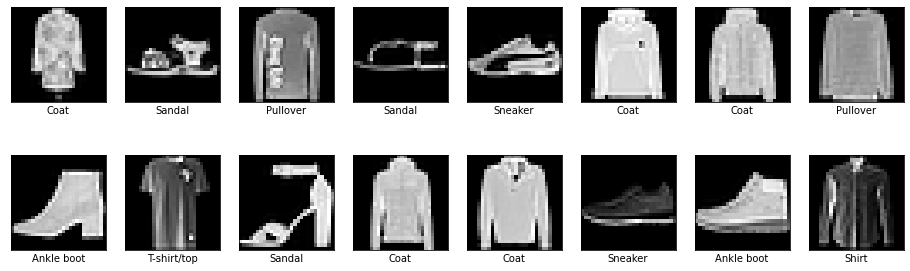

In [12]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(trainset))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(trainset[random_index][0].squeeze(), cmap = 'gray')
        ax.set_xlabel(class_names[trainset[random_index][1]])
plt.show()

## 2.  Выбираем для нашей нейросети архитектуру

Свёрточная нейронная сеть строится из нескольких разных типов слоёв: 

* [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) - Конволюция
* [MaxPooling2D](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveMaxPool2d.html?highlight=maxpool#torch.nn.AdaptiveMaxPool2d) - макспулинг
* [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html?highlight=flatten#torch.nn.Flatten) - разворачивает картинку в вектор 
* [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=nn%20linear#torch.nn.Linear) - полносвязный слой (fully-connected layer)
* [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=nn%20relu#torch.nn.ReLU) - функция активации
* [LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html?highlight=leaky#torch.nn.LeakyReLU) - leaky relu активация
* [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=nn%20dropout#torch.nn.Dropout) - дропаут.


В модели, которую мы определим ниже, на вход будет идти тензоры размера __(None, 28, 28, 1)__ и __(None, 10)__. На выходе мы будем получать вероятноть того, что объект относится к конкретному классу. Разменость __None__ заготовлена для размерности батча. 

In [13]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [14]:
DEVICE

'cuda:0'

## 2.1 Полносвязная сетка 

Соберём полносвязную сетку с нашей предыдущей пары

**Важный момент:** после последнего FC слоя `softmax` не вызывается, т.к. он заложен внутрь [`nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [15]:
RANDOM_SEED = 1234
torch.manual_seed(RANDOM_SEED)

In [ ]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
Домашнее задание:

добавить в pipeline расчет точности в дополнение к loss (функция training_loop)
улучшить качество обеих моделей (FC и CNN). В особенности CNN. Возможно, стоит изменить кол-во эпох, LR, optimizer...
Обернуть модель, функции обучения, валидации и рисования в класс. Тут нет четких критериев того, как это делать. Любые решения принимаются. Это важно для понимания того как работают классы. Можно начать с того, что поискать в интернете как обычно реализуются такие структуры.

Домашнее задание:

  добавить в pipeline расчет точности в дополнение к loss (функция training_loop)
улучшить качество обеих моделей (FC и CNN). 

  В особенности CNN. Возможно, стоит изменить кол-во эпох, LR, optimizer...
  Обернуть модель, функции обучения, валидации и рисования в класс. Тут нет четких критериев того, как это делать. 
   Любые решения принимаются. Это важно для понимания того как работают классы. Можно начать с того, что поискать в интернете как обычно реализуются такие структуры.

In [20]:
batch_size = 512
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=False)

In [61]:
## свой оптимайзер для каждого экземпляра класса
## свой оптимайзер для каждого экземпляра класса
class FC(nn.Module):
    def __init__(self): 
        super().__init__()
        self.model_layer_1 = nn.Linear(784, 64)
        nn.init.xavier_normal_(self.model_layer_1.weight)
        self.model_layer_2 = nn.BatchNorm1d(64)
        self.model_layer_4 = nn.BatchNorm1d(16)
        self.model_layer_3 = nn.Linear(16, 10)
        self.classifier = nn.Sequential(self.model_layer_1,  # 28 x 28 = 784
                                        nn.ReLU(),
                                        self.model_layer_2,
                                        nn.Linear(64, 32),
                                        nn.BatchNorm1d(32),
                                         nn.ReLU(),
                                        nn.Linear(32, 16),
                                        self.model_layer_4,
                                        nn.ReLU(),
                                        self.model_layer_3,
                                    )
        
             
    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1) # if no dim is given, then a warning will appear
        return logits,probs


from copy import deepcopy
class Main_train_loop():
    def __init__(self,batch_size,trainloader,testloader,Device,model): 
        self.batch_size = batch_size
        self.trainloader = trainloader
        self.testloader = testloader
        self.device = Device
        self.model = model
        self.loss_arr = []
        self.loss_arr_test = []
        self.metric_train = []
        self.metric_test = []
        # self.get_part_train_loop()
    def get_part_train_loop(self): #,type_of_optimizer): - добавить выборк
      self.loss_fn = nn.CrossEntropyLoss()
      self.opt = optim.SGD(self.model.parameters(), lr=0.01)

    def accurancy(self,y_predicts,data_y):
      # y_predicts = torch.tensor(y_predicts)
      self.y_predicts = y_predicts
      self.data_y = data_y
      acc = (y_predicts == data_y).sum().item() / y_predicts.size(0)
      return acc

    def train_nn(self,trainloader, model, opt, loss_fn, device):
      running_loss = []
      model.train()
      acc_list = []
      
      for i, data in enumerate(trainloader, 0):
          inputs, labels = data # Взятие данных
          inputs = inputs.to(device)

          opt.zero_grad()
          outputs,probs = model(inputs)
          y_pred = outputs.cpu().argmax(dim=1)
          loss = loss_fn(outputs.cpu(), labels)
          loss.backward()
          opt.step()
          
          running_loss.append(loss.item())
          acc_list.append(self.accurancy(y_pred,
                                           labels))

      return model, running_loss,acc_list


    def eval_nn(self,testloader, model, loss_fn, device):
        running_loss_test = []
        acc_list = []

        model.eval()
        predicts = np.array([])
        
        for i, data in enumerate(testloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)

            outputs,proba = model(inputs)
            y_pred = outputs.cpu().argmax(dim=1)
            predicts = np.append(predicts,y_pred)
            loss = loss_fn(outputs.cpu(), labels)

            running_loss_test.append(loss.item())
            acc_list.append(self.accurancy(y_pred,
                                           labels))
        return running_loss_test, predicts.astype(int),acc_list

    def training_loop(self, max_epochs=20):
      
      for epoch in range(max_epochs):        
          self.model, running_loss,acc_train = self.train_nn(self.trainloader, 
                                                             self.model,
                                         self.opt, self.loss_fn, self.device)
          running_loss_test, _,acc_eval = self.eval_nn(self.testloader,
                                         self.model,
                                         self.loss_fn, self.device)

          self.loss_arr.append(np.mean(running_loss))
          self.loss_arr_test.append(np.mean(running_loss_test))


          self.metric_train.append(np.mean(acc_train))
          self.metric_test.append(np.mean(acc_eval))
          if np.mean(acc_eval)>=np.max(self.metric_test):
            self.best_model = deepcopy(self.model)
            self.best_epoch = epoch

          if epoch % 4 == 0:
              print(f"""EPOCH {epoch} : train_loss: {self.loss_arr[-1]:.5f} 
              test_loss: {self.loss_arr_test[-1]:.5f}""")

      
        




In [62]:
model = FC()
model.to(DEVICE)
main_loop = Main_train_loop(batch_size,trainloader,testloader,DEVICE,model)
main_loop.get_part_train_loop()

In [63]:
main_loop.training_loop(max_epochs=2)

EPOCH 0 : train_loss: 1.89047 
              test_loss: 1.63672


In [65]:
main_loop.best_epoch

1

In [55]:
# 
#  Ваша LeNet сетка :) 
#  

class CNN(nn.Module):
    def __init__(self): 
        super().__init__()
        self.classifier = nn.Sequential(nn.Conv2d(in_channels = 1,
                                                  out_channels=6,
                                                  kernel_size=(5,5)),
                                        nn.Tanh(),
                                        nn.AvgPool2d(kernel_size=(2,2),
                                                    stride=(2,2)),
                                        nn.Conv2d(in_channels=6,
                                                 out_channels=16,
                                                 kernel_size=(5,5)),
                                        nn.Tanh(),
                                        nn.AvgPool2d(kernel_size=(2,2),
                                                    stride=(2,2)),
                                        nn.Conv2d(in_channels=16,
                                                 out_channels=120,
                                                 kernel_size=(4,4)),
                                        nn.Flatten(),
                                        nn.Linear(120, 84),
                                        nn.ReLU(),
                                        nn.Linear(84, 10),

                                        
                                    )
             
    def forward(self, x):
#         x = x.reshape(x.size(0), -1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1) # if no dim is given, then a warning will appear
        return logits,probs
#         return logits

1) Смотрим на оптимайзер - перевод более идеальное состояние (Адам,1e-4)
2) Добавляем в класс сохранение модели на лучшей эпохи (сохраняемся всегда по валидации)
3) Поменял функции активации на релу
4) Добавить инициализацию (хе и ксавье. 5ая неделя)
5) Понять что наступает первое - переобучение или недообучение (недообучение - эпохи идут качество на трейне такое же. Переобучение - качетсво на тесте не меняется, качество на трейне растет. Большое различие между трейном и тестом.) Если недообучение - усложнить модель - слои или количество нейронов на слое. Если переобучаемся - регуляризации (третья неделя) либо упрощаем.
6)

In [59]:
model_2 = CNN()
model_2.to(DEVICE)
main_loop_cnn = Main_train_loop(batch_size,trainloader,testloader,DEVICE,model_2)
main_loop_cnn.get_part_train_loop()
main_loop_cnn.training_loop(max_epochs=40)

EPOCH 0 : train_loss: 2.30016 
              test_loss: 2.29068
EPOCH 4 : train_loss: 1.77656 
              test_loss: 1.59920
EPOCH 8 : train_loss: 1.03541 
              test_loss: 1.02315
EPOCH 12 : train_loss: 0.90254 
              test_loss: 0.90744
EPOCH 16 : train_loss: 0.80990 
              test_loss: 0.82158
EPOCH 20 : train_loss: 0.73983 
              test_loss: 0.75368
EPOCH 24 : train_loss: 0.69661 
              test_loss: 0.71402
EPOCH 28 : train_loss: 0.66722 
              test_loss: 0.69651
EPOCH 32 : train_loss: 0.64500 
              test_loss: 0.66681
EPOCH 36 : train_loss: 0.62537 
              test_loss: 0.64627


[0.1011776194852941, 0.18619025735294117]

In [57]:
dir(main_loop_cnn)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'accurancy',
 'batch_size',
 'data_y',
 'device',
 'eval_nn',
 'get_part_train_loop',
 'loss_arr',
 'loss_arr_test',
 'loss_fn',
 'metric_test',
 'metric_train',
 'model',
 'opt',
 'testloader',
 'train_nn',
 'training_loop',
 'trainloader',
 'y_predicts']

In [18]:
trainset.data.shape

torch.Size([60000, 28, 28])

In [19]:
iter(trainloader).next()[0].shape

torch.Size([512, 1, 28, 28])

In [20]:
torch.cuda.is_available()

True

In [ ]:
# !watch -n 5 nvidia-smi

In [ ]:
device = 'cpu'  # torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model_fc = FC()
model_fc.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model_fc.parameters(), lr=0.01)

cpu


In [ ]:
model_fc()

FC(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [ ]:
for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        break

In [ ]:
logit,proba = model_fc(inputs)

In [ ]:
proba

tensor([[0.0888, 0.0427, 0.0415,  ..., 0.0903, 0.1122, 0.0724],
        [0.0814, 0.0531, 0.0369,  ..., 0.0904, 0.1488, 0.1322],
        [0.1074, 0.0965, 0.0494,  ..., 0.1063, 0.1279, 0.1066],
        ...,
        [0.0753, 0.0358, 0.0381,  ..., 0.1895, 0.0647, 0.1687],
        [0.1080, 0.0968, 0.0466,  ..., 0.0819, 0.1234, 0.0940],
        [0.0863, 0.0731, 0.0614,  ..., 0.1294, 0.1133, 0.1025]],
       grad_fn=<SoftmaxBackward>)

In [ ]:
logit

tensor([[-0.0674, -0.7985, -0.8283,  ..., -0.0510,  0.1663, -0.2719],
        [-0.0735, -0.5007, -0.8639,  ...,  0.0311,  0.5293,  0.4116],
        [ 0.1401,  0.0329, -0.6360,  ...,  0.1291,  0.3145,  0.1321],
        ...,
        [ 0.1150, -0.6279, -0.5649,  ...,  1.0382, -0.0360,  0.9221],
        [ 0.1311,  0.0217, -0.7097,  ..., -0.1455,  0.2648, -0.0077],
        [-0.0922, -0.2574, -0.4330,  ...,  0.3134,  0.1808,  0.0805]],
       grad_fn=<AddmmBackward>)

In [ ]:
def train_nn(trainloader, model, opt, loss_fn, device):
    running_loss = []

    model.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data # Взятие данных
        inputs = inputs.to(device)

        opt.zero_grad()
        outputs,probs = model(inputs)
        loss = loss_fn(outputs.cpu(), labels)
        loss.backward()
        opt.step()
        
        running_loss.append(loss.item())

    return model, running_loss


def eval_nn(testloader, model, loss_fn, device):
    running_loss_test = []

    model.eval()
    predicts = np.array([])
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)

        outputs,proba = model(inputs)
        predicts = np.append(predicts, outputs.cpu().argmax(dim=1).numpy())
        loss = loss_fn(outputs.cpu(), labels)

        running_loss_test.append(loss.item())
    return running_loss_test, predicts.astype(int)

In [ ]:
def training_loop(model, trainloader, testloader, opt, loss_fn, device, max_epochs=20):
    loss_arr = []
    loss_arr_test = []

    for epoch in range(max_epochs):        
        model, running_loss = train_nn(trainloader, model, opt, loss_fn, device)
        running_loss_test, _ = eval_nn(testloader, model, loss_fn, device)

        loss_arr.append(np.mean(running_loss))
        loss_arr_test.append(np.mean(running_loss_test))

        if epoch % 4 == 0:
            print(f'EPOCH {epoch} : train_loss: {loss_arr[-1]:.5f} test_loss: {loss_arr_test[-1]:.5f}')

    return loss_arr, loss_arr_test


def plot(loss_arr, loss_arr_test):
    plt.plot(loss_arr, label='Train loss')
    plt.plot(loss_arr_test, label='Validation loss')
    plt.legend();

In [ ]:
loss_arr, loss_arr_test = training_loop(model_fc, trainloader, testloader, opt, loss_fn, device, max_epochs=20)

EPOCH 0 : train_loss: 1.71541 test_loss: 1.45070
EPOCH 4 : train_loss: 0.70948 test_loss: 0.68674
EPOCH 8 : train_loss: 0.47581 test_loss: 0.55378
EPOCH 12 : train_loss: 0.39242 test_loss: 0.44275
EPOCH 16 : train_loss: 0.34838 test_loss: 0.41363


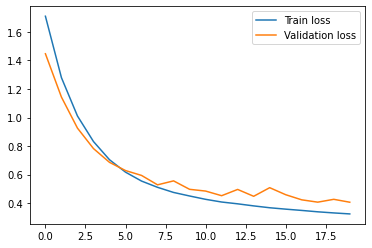

In [ ]:
plot(loss_arr, loss_arr_test)

In [ ]:
print("Loss: ", loss_arr_test[-1])

Loss:  0.4808865040540695


Можно посмотреть, где именно сетка ошибается. 

In [ ]:
_, y_pred = eval_nn(testloader, model_fc, loss_fn, device)
X_test = testset.data.numpy()
y_test = testset.targets.numpy()

errors =  y_pred != y_test

# срежем только наблюдения, где была ошибка вместе с метками
X_err = X_test[errors]
y_err = y_test[errors]
y_pred = y_pred[errors]

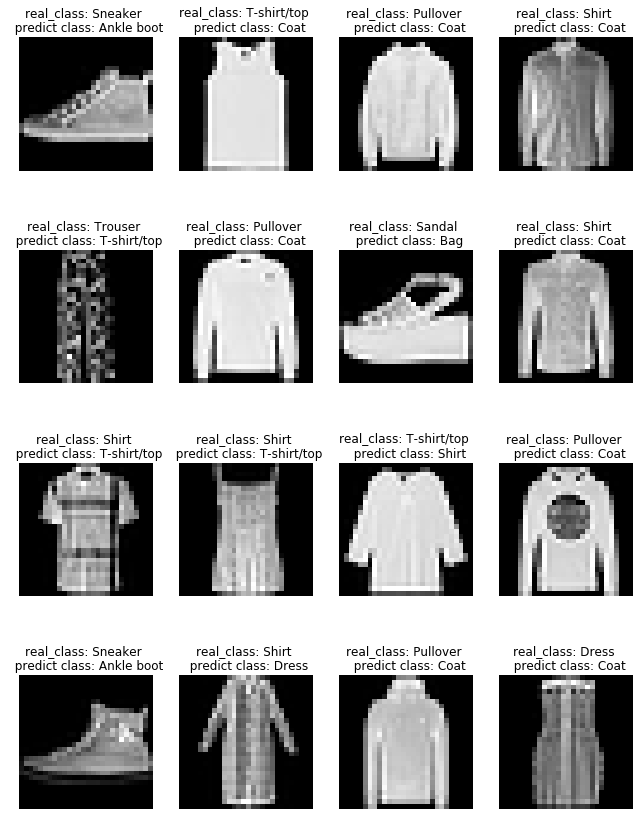

In [ ]:
cols = 4
rows = 4
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(class_names[y_err[random_index]], 
                                                                   class_names[y_pred[random_index]]))
plt.show()

## 2.2 Свёрточная сетка 

Теперь давайте соберём свёртоную сеть: 

* Свёртка с ядром $5 \times 5$ и $6$ каналами
* Tanh
* Avgpooling размера $2 \times 2$ с шагом (strides) $2$ по обеим осям
* Свёртка с ядром $5 \times 5$ и $16$ каналами
* Tanh
* Avgpooling размера $2 \times 2$ с шагом (strides) $2$ по обеим осям 
* Свёртка с ядром $4 \times 4$ и $120$ каналами
* Дальше сделайте `Flatten` и сделайте два полносвязных слоя с ReLU и $120$ и $84$ нейронами

Хорошая [статья](https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320) о том, как писать такую сетку на PyTorch

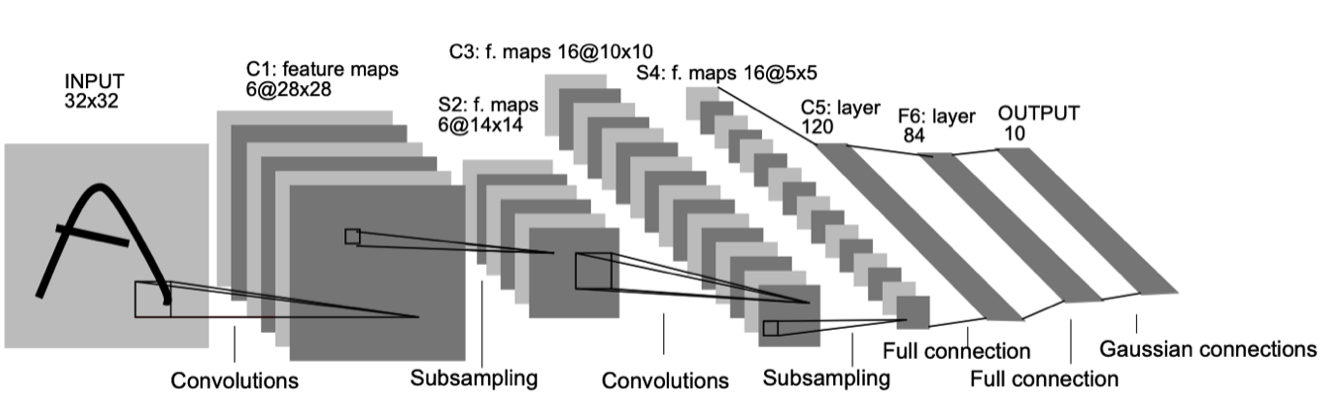

In [ ]:
display.Image('images/lenet.png', retina=True)

Также стоит держать в голове формулы для рассчета размера выхода после \
**Convolutional и Max/Avg pooling слоев:**
$$\dfrac{W−F+2P}{S}+1$$

- W is the input height/width (normally the images are squares, so there is no need to differentiate the two)
- F is the filter/kernel size
- P is the padding
- S is the stride

Теперь давайте соберём свёртоную сеть: 

* Свёртка с ядром $5 \times 5$ и $6$ каналами
* Tanh
* Avgpooling размера $2 \times 2$ с шагом (strides) $2$ по обеим осям
* Свёртка с ядром $5 \times 5$ и $16$ каналами
* Tanh
* Avgpooling размера $2 \times 2$ с шагом (strides) $2$ по обеим осям 
* Свёртка с ядром $4 \times 4$ и $120$ каналами
* Дальше сделайте `Flatten` и сделайте два полносвязных слоя с ReLU и $120$ и $84$ нейронами

Хорошая [статья](https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320) о том, как писать такую сетку на PyTorch

Также стоит держать в голове формулы для рассчета размера выхода после \
**Convolutional и Max/Avg pooling слоев:**
$$\dfrac{W−F+2P}{S}+1$$

- W is the input height/width (normally the images are squares, so there is no need to differentiate the two)
- F is the filter/kernel size
- P is the padding

In [ ]:
(28-5+0)+1

24

In [ ]:
nn.Conv3d()

In [ ]:
# 
#  Ваша LeNet сетка :) 
#  

class CNN(nn.Module):
    def __init__(self): 
        super().__init__()
        self.classifier = nn.Sequential(nn.Conv2d(in_channels = 1,
                                                  out_channels=6,
                                                  kernel_size=(5,5)),
                                        nn.Tanh(),
                                        nn.AvgPool2d(kernel_size=(2,2),
                                                    stride=(2,2)),
                                        nn.Conv2d(in_channels=6,
                                                 out_channels=16,
                                                 kernel_size=(5,5)),
                                        nn.Tanh(),
                                        nn.AvgPool2d(kernel_size=(2,2),
                                                    stride=(2,2)),
                                        nn.Conv2d(in_channels=16,
                                                 out_channels=120,
                                                 kernel_size=(4,4)),
                                        nn.Flatten(),
                                        nn.Linear(120, 84),
                                        nn.ReLU(),
                                        nn.Linear(84, 10),

                                        
                                    )
             
    def forward(self, x):
#         x = x.reshape(x.size(0), -1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1) # if no dim is given, then a warning will appear
        return logits,probs
#         return logits

In [ ]:
inputs[0][0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [ ]:
nn.Flatten()(inputs[0])

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

# model_cnn = CNN()
# model_cnn.to(device)
# loss_fn = nn.CrossEntropyLoss()
# opt = optim.SGD(model_cnn.parameters(), lr=0.01)

# loss_arr, loss_arr_test = training_loop(model_cnn, trainloader, testloader, opt, loss_fn, device, max_epochs=20)

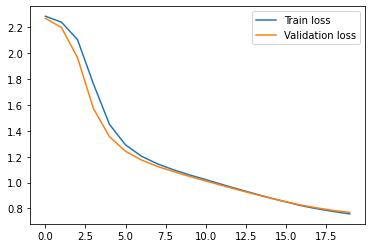

In [ ]:
plot(loss_arr, loss_arr_test)

In [ ]:
print("Loss: ", loss_arr_test[-1])

Loss:  0.7689385384321212


In [ ]:
#отрисовка результатов
y_pred = model_2.predict_classes(X_test)
errors =  y_pred != y_test

X_err = np.squeeze(X_test[errors], axis=3)
y_err = y_test[errors]
y_pred = y_pred[errors]

cols = 4
rows = 4
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(class_names[y_err[random_index]], 
                                                                   class_names[y_pred[random_index]]))
plt.show()

Точность должна была довольно сильно подскочить, но пока этого не произошло. \

**Домашнее задание:** 
1. добавить в pipeline расчет точности в дополнение к loss (функция  training_loop)
2. улучшить качество обеих моделей (FC и CNN). В особенности CNN. Возможно, стоит изменить кол-во эпох, LR, optimizer...
3. Обернуть модель, функции обучения, валидации и рисования в класс. Тут нет четких критериев того, как это делать. Любые решения принимаются. Это важно для понимания того как работают классы. Можно начать с того, что поискать в интернете как обычно реализуются такие структуры.

#### Доп инфа на посмотреть:
Посмотрите на качество получившейся модели. Добавьте строки перевода пикселей картинки на отрезок -[0;255].
Переобучите сетку. Что произошло с качеством? (сравните еще эту ситуацию в модели с батчнормом и без)

Теперь попробуйте использовать в качестве функции активации линейную функцию. Что произошло с качеством модели?
